Goal: Tell the company what their sales are due to and how to predict Sales Units with precision.

In [361]:
# Import libraries
import numpy as np
import pandas as pd
import datetime as dt
import joblib

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

# ML libraries
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score, roc_curve


In [297]:
# Import data
# Before import, the data was copied over into CSV files for upload here
tobacco_sales = pd.read_csv("Data/tobacco_sales.csv")
overnight_table = pd.read_csv("Data/overnight_table.csv")
unemployment_rate = pd.read_csv("Data/unemployment_rate.csv")

First, take a look at the tables.

In [58]:
tobacco_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 3 columns):
 #   Column                                                  Non-Null Count  Dtype         
---  ------                                                  --------------  -----         
 0   Date                                                    132 non-null    datetime64[ns]
 1   Total Sales Units Spain (excluding the Canary Islands)  132 non-null    int64         
 2   Total Sales Value Spain (excluding the Canary Islands)  132 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 3.2 KB


In [57]:
overnight_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    132 non-null    datetime64[ns]
 1   Number of working days  132 non-null    int64         
 2   Overnight stay (INE)    132 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 3.2 KB


In [55]:
unemployment_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Quarter                  44 non-null     object 
 1   Unemployment Rate (INE)  44 non-null     float64
 2   Quarter_noyear           44 non-null     object 
 3   Year                     44 non-null     object 
dtypes: float64(1), object(3)
memory usage: 1.5+ KB


Let's do some transformations. We need to do a few things such as change data types, split date columns, merging dataframes, and renaming for callability of column names.

In [298]:
# "Date" columns are currently "object" Dtype; change them into correct Dtype
tobacco_sales["Date"] = pd.to_datetime(tobacco_sales['Date'])
overnight_table["Date"] = pd.to_datetime(overnight_table['Date'])

In [299]:
# These two tables have a common column - Date. So, we will combine them into one table for ease of analysis
sales_and_tourism = pd.merge(tobacco_sales, overnight_table, on='Date', how='outer')

In [300]:
# Split out month and year into new columns
sales_and_tourism["year"] = sales_and_tourism["Date"].dt.year
sales_and_tourism["month"] = sales_and_tourism["Date"].dt.month

In [301]:
# In order to merge sales_and_tourism and unemployment_rate tables, we need a common column. We will aim to merge them through "year" and "quarter" columns
# First, create a "quarter" column in sales_and_tourism: create and call a function to identify "quarter" by the "month"
def quarterly(data):
    if data in (1,2,3):
        return 1
    if data in (4,5,6):
        return 2
    if data in (7,8,9):
        return 3
    else:
        return 4
sales_and_tourism["quarter_noyear"] = sales_and_tourism.month.apply(quarterly)

In [302]:
# Second, create the common columns in unemployment_rate: create and call a function that splits out "quarter" and "year" into two different columns 
def split_quarter(data):
    return data.split('T')[1]
unemployment_rate["quarter_noyear"] = unemployment_rate.Quarter.apply(split_quarter)

def split_year(data):
    return data.split('T')[0]
unemployment_rate["year"] = unemployment_rate.Quarter.apply(split_year)

In [303]:
# Change Dtype of "year" column so it is the same in the two tables that will be merged
unemployment_rate["year"] = unemployment_rate.year.astype(int)
unemployment_rate["quarter_noyear"] = unemployment_rate.quarter_noyear.astype(int)

In [304]:
# Merge the two tables into one Dataframe
data = pd.merge(sales_and_tourism, unemployment_rate, on=['year','quarter_noyear'], how='outer')

In [305]:
# Rename columns for easy callability
data = data.rename(columns={'Total Sales Units Spain (excluding the Canary Islands)': 'sales_units', 
                     'Total Sales Value Spain (excluding the Canary Islands)': 'sales_value',
                     'Number of working days': 'working_days',
                     'Overnight stay (INE)':'overnight_stays',
                     'Unemployment Rate (INE)':'unemploy_rate',
                     'Quarter':'year_quarter',
                     'quarter_noyear':'quarter',
                     'Date':'date'
                     })

What other data could be useful for this analysis?

Metrics about the economy, such as measures of inflation, could be interesting. We can add the Consumer Price Index, a popular measure of inflation and deflation.
https://ine.es/jaxiT3/Datos.htm?t=50902

In [306]:
cpi = pd.read_csv("Data/cpi.csv", delimiter=';')

In [307]:
# Check categories
#cpi["ECOICOP Groups"].value_counts()
cpi["Type of data"].value_counts()

Index                  3484
Monthly change         3484
Annual change          3484
Year-to-date change    3484
Name: Type of data, dtype: int64

In [308]:
# Limit to "Overall index" and "02 Alcoholic beverages and tobacco"
cpi = cpi[cpi["ECOICOP Groups"].isin(["Overall index","02 Alcoholic beverages and tobacco"])]

In [309]:
# Limit to "Index" only
cpi = cpi[cpi["Type of data"]=="Index"]

In [310]:
# Split "Period" column into "year" and "month"
def split_month(data):
    return data.split('M')[1]
cpi["month"] = cpi.Period.apply(split_month)

def split_year(data):
    return data.split('M')[0]
cpi["year"] = cpi.Period.apply(split_year)

In [311]:
# "Total" column has some formatting issues. Let's fix them
cpi['total'] = cpi['Total,,,'].str.replace(',', '')

# Convert the 'total' column to float
cpi['total'] = cpi['total'].astype(float)

In [312]:
# "Type of data", "Period", and "Total,,," are no longer needed; remove
cpi = cpi.drop(["Period","Type of data","Total,,,"],axis=1)

In [313]:
cpi.head()

,ECOICOP Groups,month,year,total
0,Overall index,04,2024,115.472
1,Overall index,03,2024,114.674
2,Overall index,02,2024,113.807
3,Overall index,01,2024,113.404
4,Overall index,12,2023,113.308


In [314]:
# Change Dtype of "month" and "year" columns to allow merging with "data" Dataframe
cpi["month"] = cpi.month.astype(int)
cpi["year"] = cpi.year.astype(int)

In [315]:
# Rearrange "cpi" Dataframe so there is one row per date
total_cpi = pd.merge(cpi[cpi["ECOICOP Groups"]=="Overall index"], cpi[cpi["ECOICOP Groups"]=="02 Alcoholic beverages and tobacco"], on=['year','month'], how='outer')

In [316]:
# Now rename columns to ensure clarity
total_cpi = total_cpi.rename(columns={'total_x': 'total_cpi',
                        'total_y':'alc_tobacco_cpi'
                     })

# And then drop the CPI category columns.
total_cpi = total_cpi.drop(["ECOICOP Groups_y","ECOICOP Groups_x"],axis=1)

In [317]:
# Check that the CPI data is ready to merge with "data" Dataframe
total_cpi.head()

,month,year,total_cpi,alc_tobacco_cpi
0,4,2024,115.472,116.374
1,3,2024,114.674,116.088
2,2,2024,113.807,116.028
3,1,2024,113.404,114.299
4,12,2023,113.308,111.679


In [318]:
# We use inner join here because we don't want to include all the dates in the CPI data that we do not have in our sales data
total = pd.merge(data, total_cpi, on=['year','month'], how='inner')

In [320]:
# Change the order of columns in the Dataframe to put all temporal columns together
# We also put sales columns at the end, as that is the target for this problem
total = total[["date","year_quarter","year","quarter","month","working_days","overnight_stays","unemploy_rate","total_cpi","alc_tobacco_cpi","sales_units","sales_value"]]

In [455]:
# We should also calculate the price of tobacco. We can do that by calculating: sales_value / sales_units
total["avg_price"] = total["sales_value"] / total["sales_units"]

In [456]:
# Take a look at the total dataset.
total.head()

,date,year_quarter,year,quarter,month,working_days,overnight_stays,unemploy_rate,total_cpi,alc_tobacco_cpi,sales_units,sales_value,avg_price
0,2013-01-01,2013T1,2013,1,1,26,11887105,26.94,93.188,90.497,202371468,852799118,4.214028
1,2013-02-01,2013T1,2013,1,2,24,13104722,26.94,93.349,90.858,162786803,689228787,4.233935
2,2013-03-01,2013T1,2013,1,3,25,18815829,26.94,93.678,90.918,180822109,767404565,4.243975
3,2013-04-01,2013T2,2013,2,4,26,19135958,26.06,94.028,90.961,197087313,838424832,4.254078
4,2013-05-01,2013T2,2013,2,5,26,26359256,26.06,94.201,91.135,233796351,994467519,4.253563


In [457]:
# Save the cleaned and combined data down to use later
total.to_csv("data/cleaned_data.csv", index=False)

The data is ready to work with. Now, let's do some exploratory analysis.

In [458]:
data = pd.read_csv("data/cleaned_data.csv")

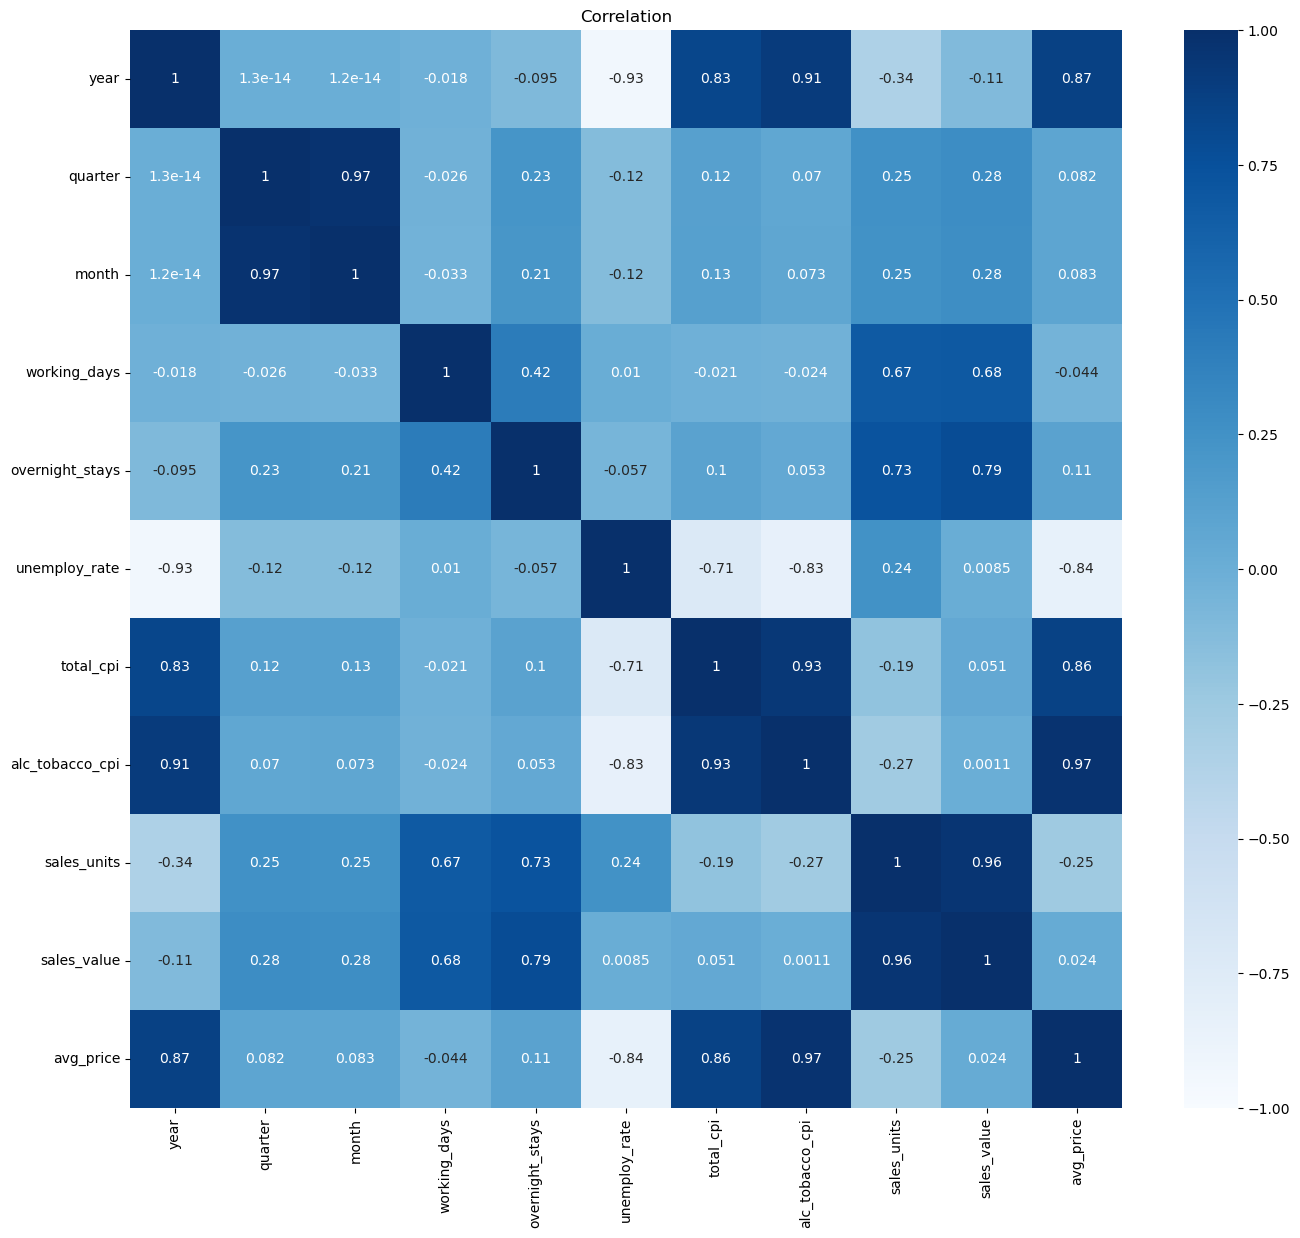

In [459]:
# Begin with a quick correlation visual

# Specify numeric columns
num = data.select_dtypes(include='number')

corr = num.corr()

# Visualize 
plt.figure(figsize=(16,14))
sns.heatmap(corr,annot=True,vmin=-1.0,vmax=1.0,cmap="Blues")
plt.title("Correlation")
plt.show()


# On a first pass, we see some obvious correlations such as quarter and month, and sales_value and sales_units
# We see also some interesting correlations such as how overnight_stays and working_days correlates with the sales columns
# We see that unemployment_rate has some correlation with sales_units but not sales_value
# Alcohol and Tobacco CPI is more negatively correlated than Total CPI (with sales_units)

In [460]:
# Let's try to understand previous trends in the sales data

# Create the figure
fig = go.Figure()

# Add first line for sales_units
fig.add_trace(
    go.Scatter(
        x=data['date'], 
        y=data['sales_units'], 
        name='Sales Units',
        mode='markers+lines',
        marker=dict(size=6, color='darkblue'),
        line=dict(width=2, color='darkblue'),
        yaxis='y1'
    )
)

# Add second line for another_metric
fig.add_trace(
    go.Scatter(
        x=data['date'], 
        y=data['sales_value'], 
        name='Sales Value',
        mode='markers+lines',
        marker=dict(size=6, color='lightblue'),
        line=dict(width=2, color='lightblue'),
        yaxis='y2'
    )
)

# Update layout to include two y-axes
fig.update_layout(
    title='Sales Units and Sales Value over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Sales Units'),
    yaxis2=dict(
        title='Sales Value',
        anchor='x',
        overlaying='y',
        side='right'
    ),
    hovermode='x unified'
)

# Show the figure
fig.show()


# There are clearly seasonality trends in the sales data; this chart also confirms that sales unit and value are extremely correlated.

In [461]:
# Let's double click into this seasonality hypothesis by taking a look at Sale Values throughout the year
data.head()

,date,year_quarter,year,quarter,month,working_days,overnight_stays,unemploy_rate,total_cpi,alc_tobacco_cpi,sales_units,sales_value,avg_price
0,2013-01-01,2013T1,2013,1,1,26,11887105,26.94,93.188,90.497,202371468,852799118,4.214028
1,2013-02-01,2013T1,2013,1,2,24,13104722,26.94,93.349,90.858,162786803,689228787,4.233935
2,2013-03-01,2013T1,2013,1,3,25,18815829,26.94,93.678,90.918,180822109,767404565,4.243975
3,2013-04-01,2013T2,2013,2,4,26,19135958,26.06,94.028,90.961,197087313,838424832,4.254078
4,2013-05-01,2013T2,2013,2,5,26,26359256,26.06,94.201,91.135,233796351,994467519,4.253563


In [462]:
# Let's double click into this seasonality hypothesis by taking a look at Sale Values throughout the year

# Visualize whether we see the same patterns through the years
# Note that making each line the same color was a conscious choice - it helps us focus on the clumped trends, not individual lines.
fig = px.line(data, x='month', y='sales_units', color='year',
              title='Sales Units throughout the Year',
              color_discrete_map={year: 'darkblue' for year in data['year'].unique()})
fig.update_layout(showlegend=False)
fig.show()

# We can easily see that there is a general spike in sales in the summer, and a dip in the late winter
# We can also see that one year in particular has much lower sales than the other years. Looking more closely, we see that it is 2020 - the year of Covid.
# We should consider adding in Covid data to try to better understand how it affects sales

At this point, we considered adding Covid data in from the WHO's Covid-19 Dashboard. We wanted to understand better how exactly Covid-19 numbers were affecting sales.
However, we decided not to do so, because many countries have stopped tracking or publishing data on the population Covid-19 spread.
Because data is inconsistent and unreliable, it does not make sense to include such a feature in our model, especially because it is unlikely to spike to the same levels as 2020 again.

We decided instead to consider removing 2020 data from our model entirely, because the other years of data are much more representative of what can be expected going forward.

https://data.who.int/dashboards/covid19/data?n=c

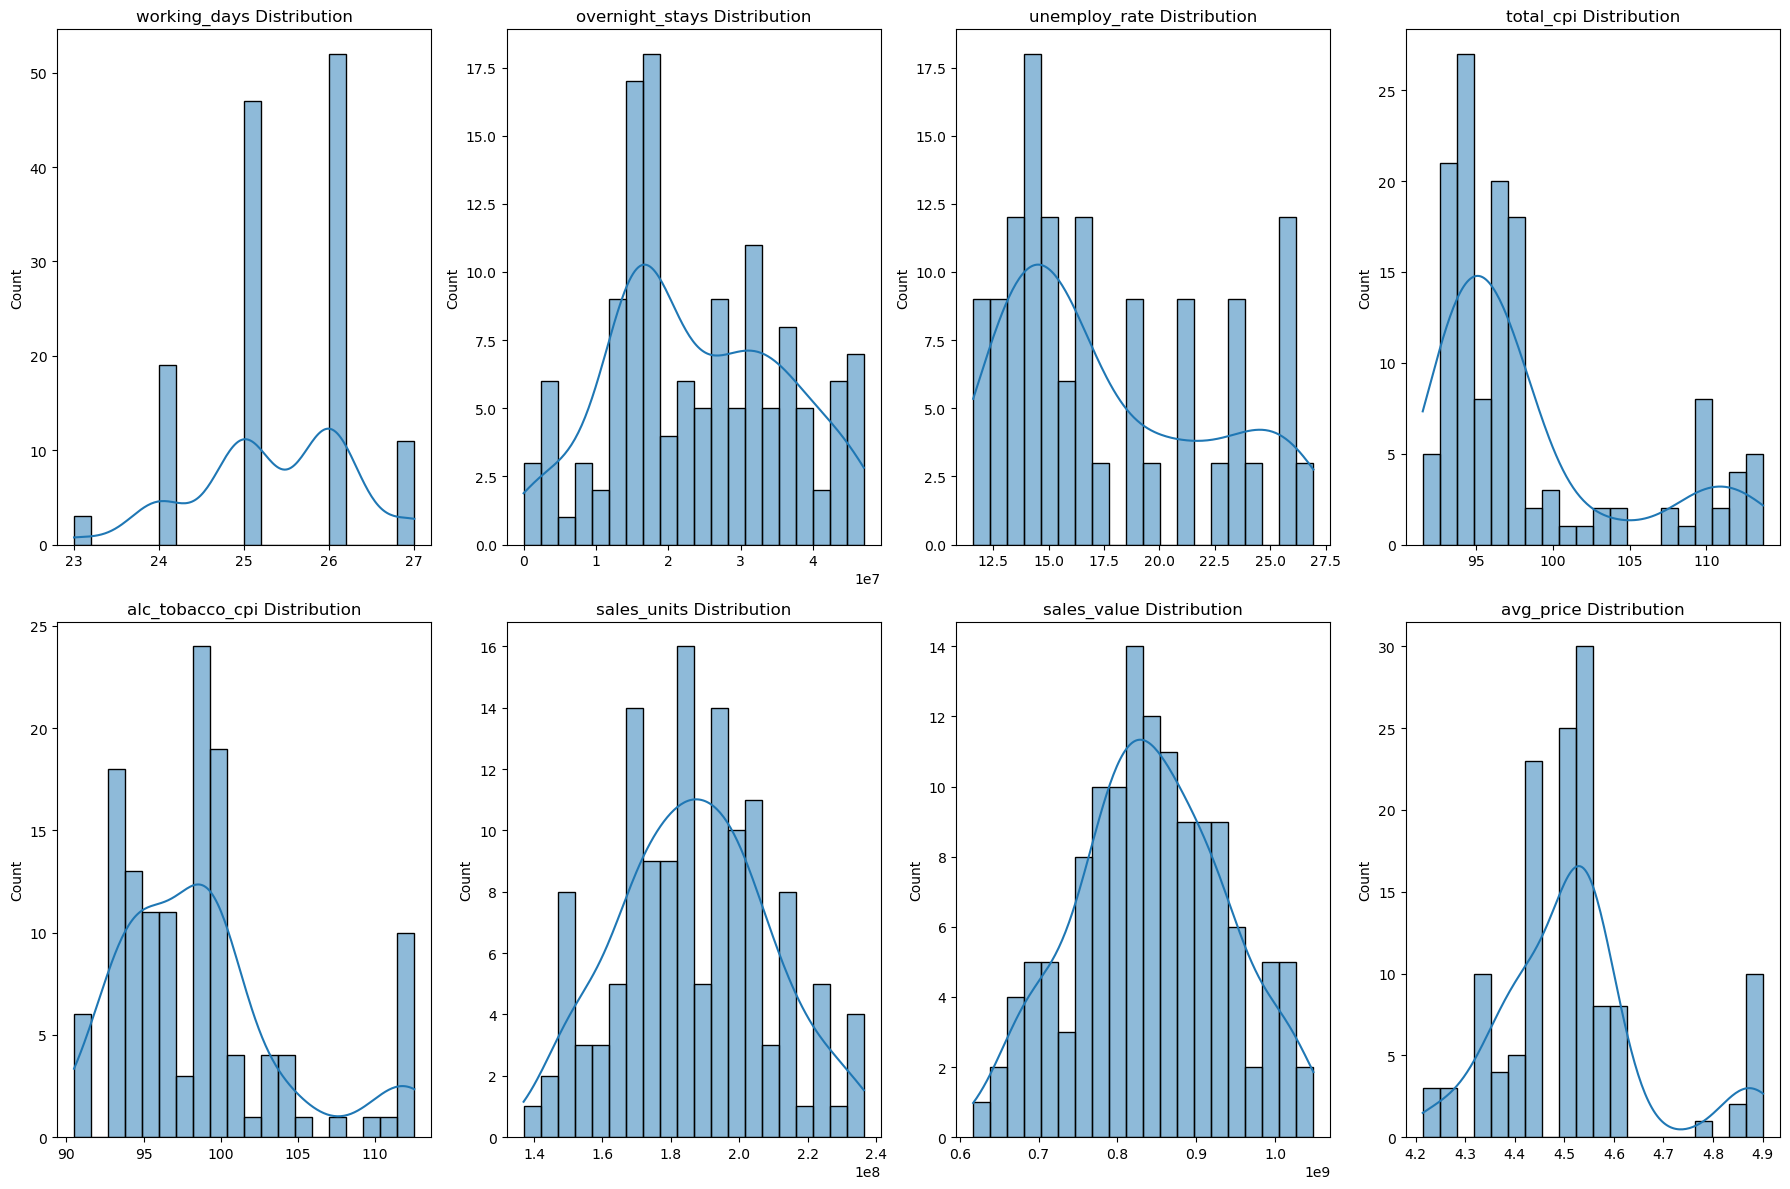

In [463]:
# Check on feature distributions next

num_drop = num.drop(["year", "quarter", "month"], axis=1)

# Calculate the number of rows and columns needed for subplots
num_features = len(num_drop.columns)
num_rows = (num_features - 1) // 4 + 1 
num_cols = min(num_features, 4) 

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(18, 12))
fig.subplots_adjust(hspace=0.5)

# Iterate through numerical features and plot distributions
for i, feature in enumerate(num_drop):
    row, col = divmod(i, num_cols)
    sns.histplot(num_drop[feature], bins=20, kde=True, ax=axes[row, col])
    axes[row, col].set_title(f'{feature} Distribution')
    axes[row, col].set_xlabel('')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


# The feature distributions appear to be fairly normally distributed, except for CPI metrics.

In [473]:
# We need to look as well at how avg_price has fluctuated over time
fig = px.line(data, x='date', y='avg_price', title='Average Price through Time')
fig.show()

# There is a clear price increase occuring here.

We need to remove some features before training our model. We are going to remove some of the date features, because we do not want to keep features that give us the same information (for example, month and quarter). We are also going to remove sales_value, because we cannot know that in advance and so it is a poor model feature. Lastly, we will remove total_cpi, because alc_tobacco_cpi has a higher correlation with our target variable and we only need one of the two CPI features.

We keep avg_price in because even though we estimated this variable, price is a variable that must be known to management. Plus, price is integral to estimating sales.

In [506]:
# Drop unwanted features
dropped = data.drop(["date","year_quarter","quarter","sales_value","total_cpi"],axis=1)

Next, we need to train a model.

First, we scale the features. We will use MinMax Scaling because in this case, interpretability and ease of explanation is paramount.

Then, we will train a Linear Regression.

In [475]:
# Split data into features and target
X = dropped.drop(['sales_units'], axis=1)
y = dropped['sales_units']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [476]:
# Define the pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('regressor', LinearRegression()) 
])

# Fit the scaler and the regressor
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('regressor', LinearRegression())])

In [477]:
# First evaluation of the model
# We chose to focus on MAE and R^2 as evaluation metrics. 
# MAE allows for straightforward interpretation of average error, and R^2 allows us to understand the proportion of variance explained by the model

predictions = pipeline.predict(X_train)

mae = mean_absolute_error(y_train, predictions)
r2 = r2_score(y_train, predictions)

print("Mean Absolute Error (MAE):", mae)
print("R-squared (R^2) Score:", r2)

# 85% of the train variance is explained by this model

Mean Absolute Error (MAE): 6801636.974163803
R-squared (R^2) Score: 0.8499918629229475


In [491]:
# Let's try Ridge Regression, a type of linear regression that adds in a regularization technique
# Choosing Ridge over Lasso because we have very few features

pipeline_ridge = Pipeline([
    ('scaler', MinMaxScaler()),
    ('regressor', Ridge())
])

param_grid = {'regressor__alpha': np.logspace(-4, 4, 100)}

#grid_search = GridSearchCV(pipeline_ridge, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search = GridSearchCV(pipeline_ridge, param_grid, cv=5, scoring='r2')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
#best_score = -grid_search.best_score_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best cross-validated R^2:", best_score)


# 80% of variance is explained by this model. Not as good.
# We are going to go back to the first model

Best parameters: {'regressor__alpha': 0.521400828799969}
Best cross-validated R^2: 0.7946228321430009


In [479]:
# Extract feature importance from the linear regression model and put into a Dataframe

regressor = pipeline.named_steps['regressor']

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': regressor.coef_
})

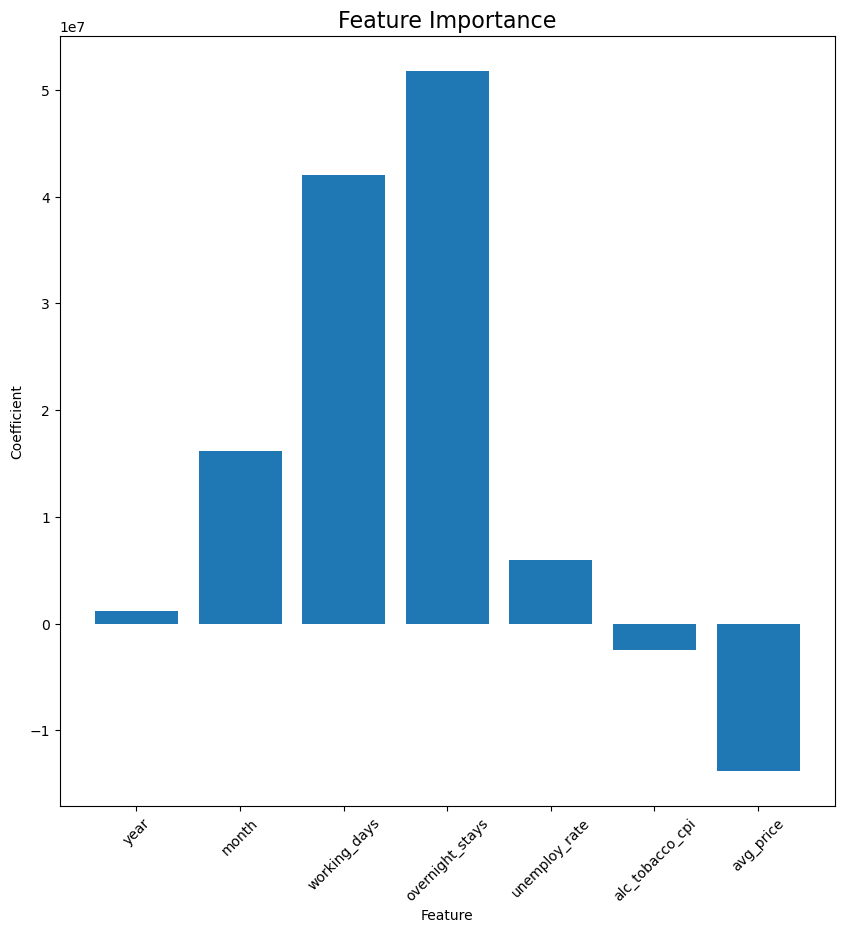

In [481]:
# Let's plot feature importance.

plt.figure(figsize=(10,10))
plt.bar(feature_importance["Feature"], feature_importance["Coefficient"])
plt.title('Feature Importance', fontsize=16)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.xticks(rotation=45)
plt.show()

# We see that "working_days" and "overnight_stays" have the strongest importance in this model - this makes logical sense
# We can also see that "alc_tobacco_cpi" and "avg_price" metrics have an inverse correlation with sales - also logical.
# As inflation rises, consumers buy less; as price rises, consumers buy less.

"year" and "alc_tobacco_cpi" have very low importance. We considered removing them for increased interpretability (fewer features), but because we are instructed to use all variables that may affect sales, we kept them in.

A question to consider: Considering the Total Sales Units model you developed in the previous section, what impact would a 10% increase in the price of tobacco in 2022 have on sales units? 

In [508]:
# Duplicate Dataframe that feeds into the model
dupl = dropped.copy()

# Add a new column that is 110% (a 10% increase) in the price
dupl["price_110%"] = dupl["avg_price"]*1.1

# Drop price without the 10% increase and drop sales_units without the 10% increase
dupl = dupl.drop(["avg_price","sales_units"],axis=1)

# Limit data to 2022 only
dupl = dupl[dupl["year"]==2022]

In [518]:
# DO STATS TESTS MAKE SURE THIS IS SIGNIFICANTTTTTTTT
# IS SHE PROFITABLE ?????
dupl

,year,month,working_days,overnight_stays,unemploy_rate,alc_tobacco_cpi,price_110%
108,2022,1,24,10598385,13.65,101.308,5.044886
109,2022,2,24,13623546,13.65,102.227,5.043121
110,2022,3,27,17632648,13.65,102.787,5.048089
111,2022,4,25,25197638,12.48,103.127,5.052686
112,2022,5,26,29785395,12.48,103.146,5.060884
113,2022,6,26,35111326,12.48,103.589,5.063546
114,2022,7,26,42121775,12.67,103.967,5.056064
115,2022,8,26,46140100,12.67,104.243,5.066419
116,2022,9,26,35999861,12.67,104.399,5.042082
117,2022,10,25,29865924,12.87,104.582,5.060637
